In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import os
import torch.nn as nn
import numpy as np
from sklearn.model_selection import KFold
from PIL import Image
import torchvision
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import copy
import math

# Define the dataset path
data_dir = '/content/drive/My Drive/Dataset'

# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)



In [3]:
def imshow(img, title=None):
    """Show an image with matplotlib."""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def show_batch(dataloader, class_names):
    """Show a batch of images from the dataloader."""
    # Get a batch of images
    inputs, labels = next(iter(dataloader))

    # Make a grid from the batch
    grid = torchvision.utils.make_grid(inputs)

    # Show the images
    imshow(grid, title=[class_names[x] for x in labels])



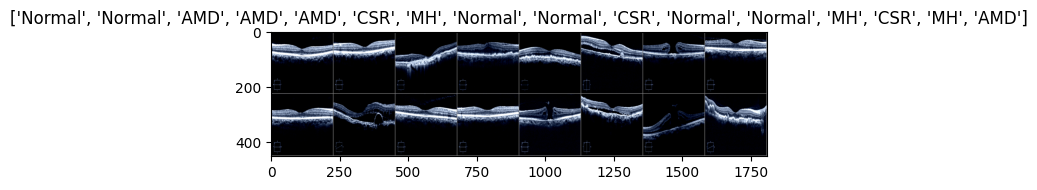

In [4]:
# Define the transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset
data_dir = '/content/drive/My Drive/Dataset'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
class_names = full_dataset.classes

# Function to split dataset by class sequentially
def split_dataset_by_class_sequential(dataset, test_ratio=0.2, val_ratio=0.1):
    train_indices = []
    val_indices = []
    test_indices = []
    targets = dataset.targets

    for class_index in range(len(dataset.classes)):
        class_indices = [i for i, target in enumerate(targets) if target == class_index]
        class_size = len(class_indices)
        class_test_size = int(math.ceil(class_size * test_ratio))
        class_val_size = int(math.ceil((class_size - class_test_size) * val_ratio))

        class_test_indices = class_indices[:class_test_size]
        class_val_indices = class_indices[class_test_size:class_test_size + class_val_size]
        class_train_indices = class_indices[class_test_size + class_val_size:]

        test_indices.extend(class_test_indices)
        val_indices.extend(class_val_indices)
        train_indices.extend(class_train_indices)

    return train_indices, val_indices, test_indices

# Split the dataset
train_indices, val_indices, test_indices = split_dataset_by_class_sequential(full_dataset)

# Create train, validation, and test datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Update transforms for validation and test sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
batch_size = 16
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Display sample images from the training set
show_batch(dataloaders['train'], class_names)


In [5]:
# Load Pretrained EfficientNet Model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Function with Early Stopping
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            elif phase == 'val':
                epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Train the model
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=10)

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/efficientnet_oct_model.pth')

# Evaluate on test set
model.eval()
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / dataset_sizes['test']
print(f'Test Acc: {test_acc:.4f}')



Epoch 0/9
----------
train Loss: 0.7044 Acc: 0.7488
val Loss: 0.8529 Acc: 0.7143
Epoch 1/9
----------
train Loss: 0.3780 Acc: 0.8916
val Loss: 2.1234 Acc: 0.4286
Epoch 2/9
----------
train Loss: 0.2561 Acc: 0.9064
val Loss: 0.5463 Acc: 0.8571
Epoch 3/9
----------
train Loss: 0.1440 Acc: 0.9458
val Loss: 0.8871 Acc: 0.7755
Epoch 4/9
----------
train Loss: 0.2865 Acc: 0.9138
val Loss: 0.5896 Acc: 0.7551
Epoch 5/9
----------
train Loss: 0.0874 Acc: 0.9704
val Loss: 0.5416 Acc: 0.8776
Epoch 6/9
----------
train Loss: 0.0807 Acc: 0.9778
val Loss: 0.4412 Acc: 0.8980
Epoch 7/9
----------
train Loss: 0.0407 Acc: 0.9901
val Loss: 0.6160 Acc: 0.9184
Epoch 8/9
----------
train Loss: 0.0586 Acc: 0.9803
val Loss: 0.7775 Acc: 0.8571
Epoch 9/9
----------
train Loss: 0.0335 Acc: 0.9877
val Loss: 0.5404 Acc: 0.8776
Best val Acc: 0.918367
Test Acc: 0.9316
